In [1]:
import os
import dotenv
dotenv.load_dotenv()

True

# External Test Provider Demo

##  Outline

* [Introduction](#Introduction)
* [Isolation Forest Test Development](#Isolation-Forest-Test-Development)
* [New Test Creation](#New-Test-Creation)
* [External Test Providers](#External-Test-Providers)
    * [Test Provider Flow Diagram](#Test-Provider-Flow-Diagram)
    * [Local Test Provider](#Local-Test-Provider)
    * [Github Repo Test Provider](#Github-Repo-Test-Provider)
* [New Test Registration](#New-Test-Registration)
* [Template Updates](#Template-Updates)
* [Template Execution](#Template-Execution)

# Introduction

This notebook demonstrates how to use a custom test provider to be able to use custom tests with the Validmind Developer Framework.
In the notebook, we load a couple different demo test providers and register them with the Validmind framework to be able to run a template that utilizes those tests.

# Isolation Forest Test Development

### Import Libraries

In [2]:
#Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Importing IsolationForest module
from sklearn.ensemble import IsolationForest

#Importing Line2D for marking legend in graph
from matplotlib.lines import Line2D

#Just to filter out warnings- Well I hate warnings popping on the screen 
import warnings
warnings.filterwarnings("ignore")

#We set the seed for random, so we generate same results whenever we run
np.random.seed(0)

### Generate Data

In [3]:
#Now we will generate datasets 

#Generating a normally distributed data set for training
X = 0.3 * np.random.randn(100, 2)
X_train_normal = np.r_[X + 2, X - 2]

#Generating outliers for training
X_train_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

#Generating a normally distributed dataset for testing
X = 0.3 * np.random.randn(20, 2)
X_test_normal = np.r_[X + 2, X - 2]

#Generating outliers for testing
X_test_outliers = np.random.uniform(low=-4, high=4, size=(10, 2))

### Visualize Data

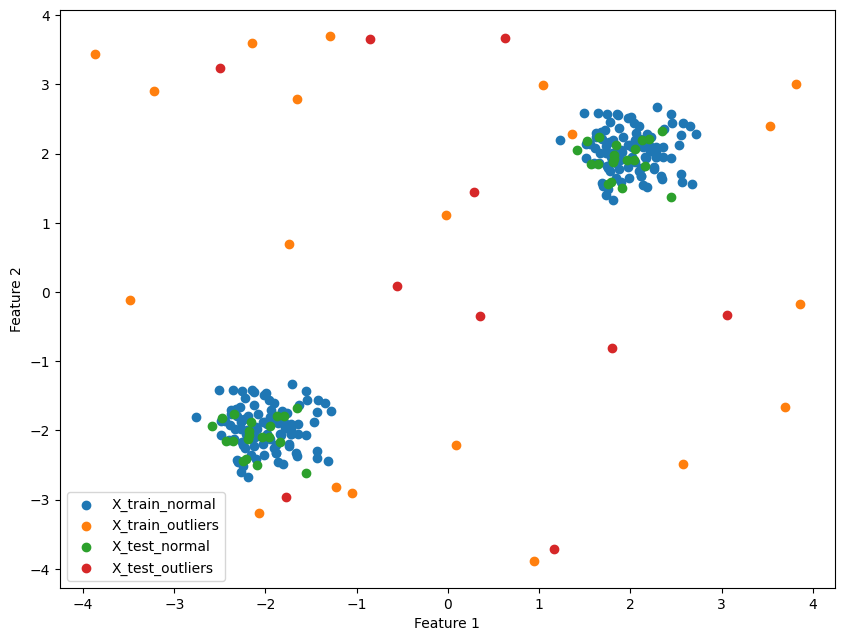

In [4]:
#Plotting and visualising the data points
plt.figure(figsize=(10,7.5))
plt.scatter(X_train_normal[:,0],X_train_normal[:,1],label='X_train_normal')
plt.scatter(X_train_outliers[:,0],X_train_outliers[:,1],label='X_train_outliers')
plt.scatter(X_test_normal[:,0],X_test_normal[:,1],label='X_test_normal')
plt.scatter(X_test_outliers[:,0],X_test_outliers[:,1],label='X_test_outliers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

### Concatenate Normal and Outlier Data

In [5]:
#Now we will append the normal points and outliers- train and test separately
X_train=np.append(X_train_normal,X_train_outliers,axis=0)
# X_train = np.concatenate([X_train,X_train],axis=1)

X_test=np.append(X_test_normal,X_test_outliers,axis=0)
# X_test = np.concatenate([X_test,X_test],axis=1)

### Train Isolation Forest Model

In [6]:
#Training with isolation forest algorithm
clf = IsolationForest(random_state=0, contamination=0.1)
clf.fit(X_train)

#Now we predict the anomaly state for data
y_train=clf.predict(X_train)
y_test=clf.predict(X_test)

### Predict Outliers

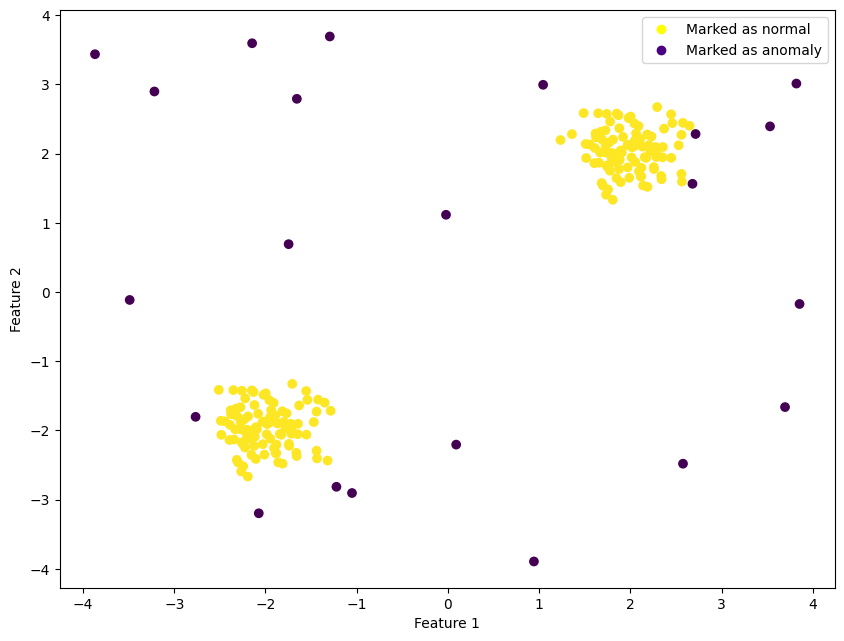

In [7]:
#Now we will plot and visualize how good our algorithm works for training data
#y_train(the state) will mark the colors accordingly
plt.figure(figsize=(10,7.5))
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

 
#This is to set the legend appropriately
legend_elements = [Line2D([], [], marker='o', color='yellow', label='Marked as normal',linestyle='None'),
                   Line2D([], [], marker='o', color='indigo', label='Marked as anomaly', linestyle='None')]
plt.legend(handles=legend_elements)

# New Test Creation

We can now take the code developed above and create a new Validmind `Test` class out of it that will be compatible with the Validmind framework.

### Test Class Definition

In [8]:
import itertools
from dataclasses import dataclass

import seaborn as sns
#Importing IsolationForest module
from sklearn.ensemble import IsolationForest

from validmind.vm_models import Figure, Metric


@dataclass
class MyIsolationForest(Metric):
    """
    Isolation Forest.
    This class implements the Isolation Forest algorithm for anomaly detection.
    Attributes:
        name (str): The name of the Isolation Forest.
        default_params (dict): The default parameters for the Isolation Forest.
        required_inputs (list): The required inputs for running the Isolation Forest.

    Methods:
        description(): Returns the description of the Isolation Forest.
        run(): Runs the Isolation Forest algorithm.
    """

    name = "isolation_forest"
    default_params = {"random_state": 0,
                      "contamination" : 0.1,
                      "features_columns": None}    
    required_inputs = ["dataset"]

    def description(self):
        return """
        The Isolation Forest test is an algorithm used for anomaly detection in datasets. It is based
        on the concept of isolating anomalies rather than identifying normal data points. The test builds an ensemble
        of isolation trees, which are binary trees created by randomly selecting features and splitting the data based
        on random thresholds.

        The main idea behind the Isolation Forest test is that anomalies are likely to be isolated quickly in these trees
        compared to normal instances. Anomalies are expected to have shorter average path lengths in the trees,
        as they are different from the majority of the data points.

        It's important to note that the Isolation Forest test assumes anomalies are less frequent and have different properties
        compared to normal instances. However, it may not be as effective in detecting anomalies that are close to each other
        or in datasets where anomalies are more prevalent."""

    def run(self):

        if self.params["features_columns"] is None:
            features_list = self.dataset.get_features_columns()
        else:
            features_list = self.params["features_columns"]

        # Check if all elements from features_list are present in the feature columns
        all_present = all(
            elem in self.dataset.get_features_columns() for elem in features_list
        )
        if not all_present:
            raise ValueError(
                "The list of feature columns provided do not match with "
                + "training dataset feature columns"
            )
        
        dataset = self.dataset.df

        # Training with isolation forest algorithm
        clf = IsolationForest(random_state=self.params["random_state"], contamination=self.params["contamination"])
        clf.fit(dataset)
        y_pred = clf.predict(dataset)
        
        # test passes if there aren't any outliers
        passed = not any(y_pred == -1)
        test_figures = []
        combination_pairs = list(itertools.combinations(features_list, 2))
        for feature1, feature2 in combination_pairs:
            fig = plt.figure(figsize=(10,7.5))
            ax = sns.scatterplot(data=dataset, x=feature1, y=feature2, hue=y_pred, palette="bright")
            handles, labels  =  ax.get_legend_handles_labels()
            labels = list(map(lambda x: x.replace('-1', 'Outliers'), labels))
            labels = list(map(lambda x: x.replace('1', 'Inliers'), labels))
            ax.legend(handles, labels)
            # Do this if you want to prevent the figure from being displayed
            plt.close("all")

            test_figures.append(
                Figure(
                for_object=self,
                key=f"{self.name}:{feature1}_{feature2}",
                figure=fig,
                )
            )

        return self.cache_results(figures=test_figures)

# External Test Providers

Now that we have created a new test, how do we start making use of it in the Validmind framework? This is where our new External Test Provider feature comes in. As users of the framework develop their own tests which will live outside of the framework source code, how will those tests get seamlessly plugged into the framework? The answer is through the use of a `ExternalTestProvider` class. We provide two test provider implementations out of the box, one that will load tests from a local directory and one that will load tests from a Github repository. Each can be configured to point to where the tests are located and then registered with the Validmind framework under a namespace. Once registered, the framework will be able to identify content IDs in templates that are associated with the namespace and will be able to then load the tests matching those IDs using the test provider.

### Test Provider Flow Diagram

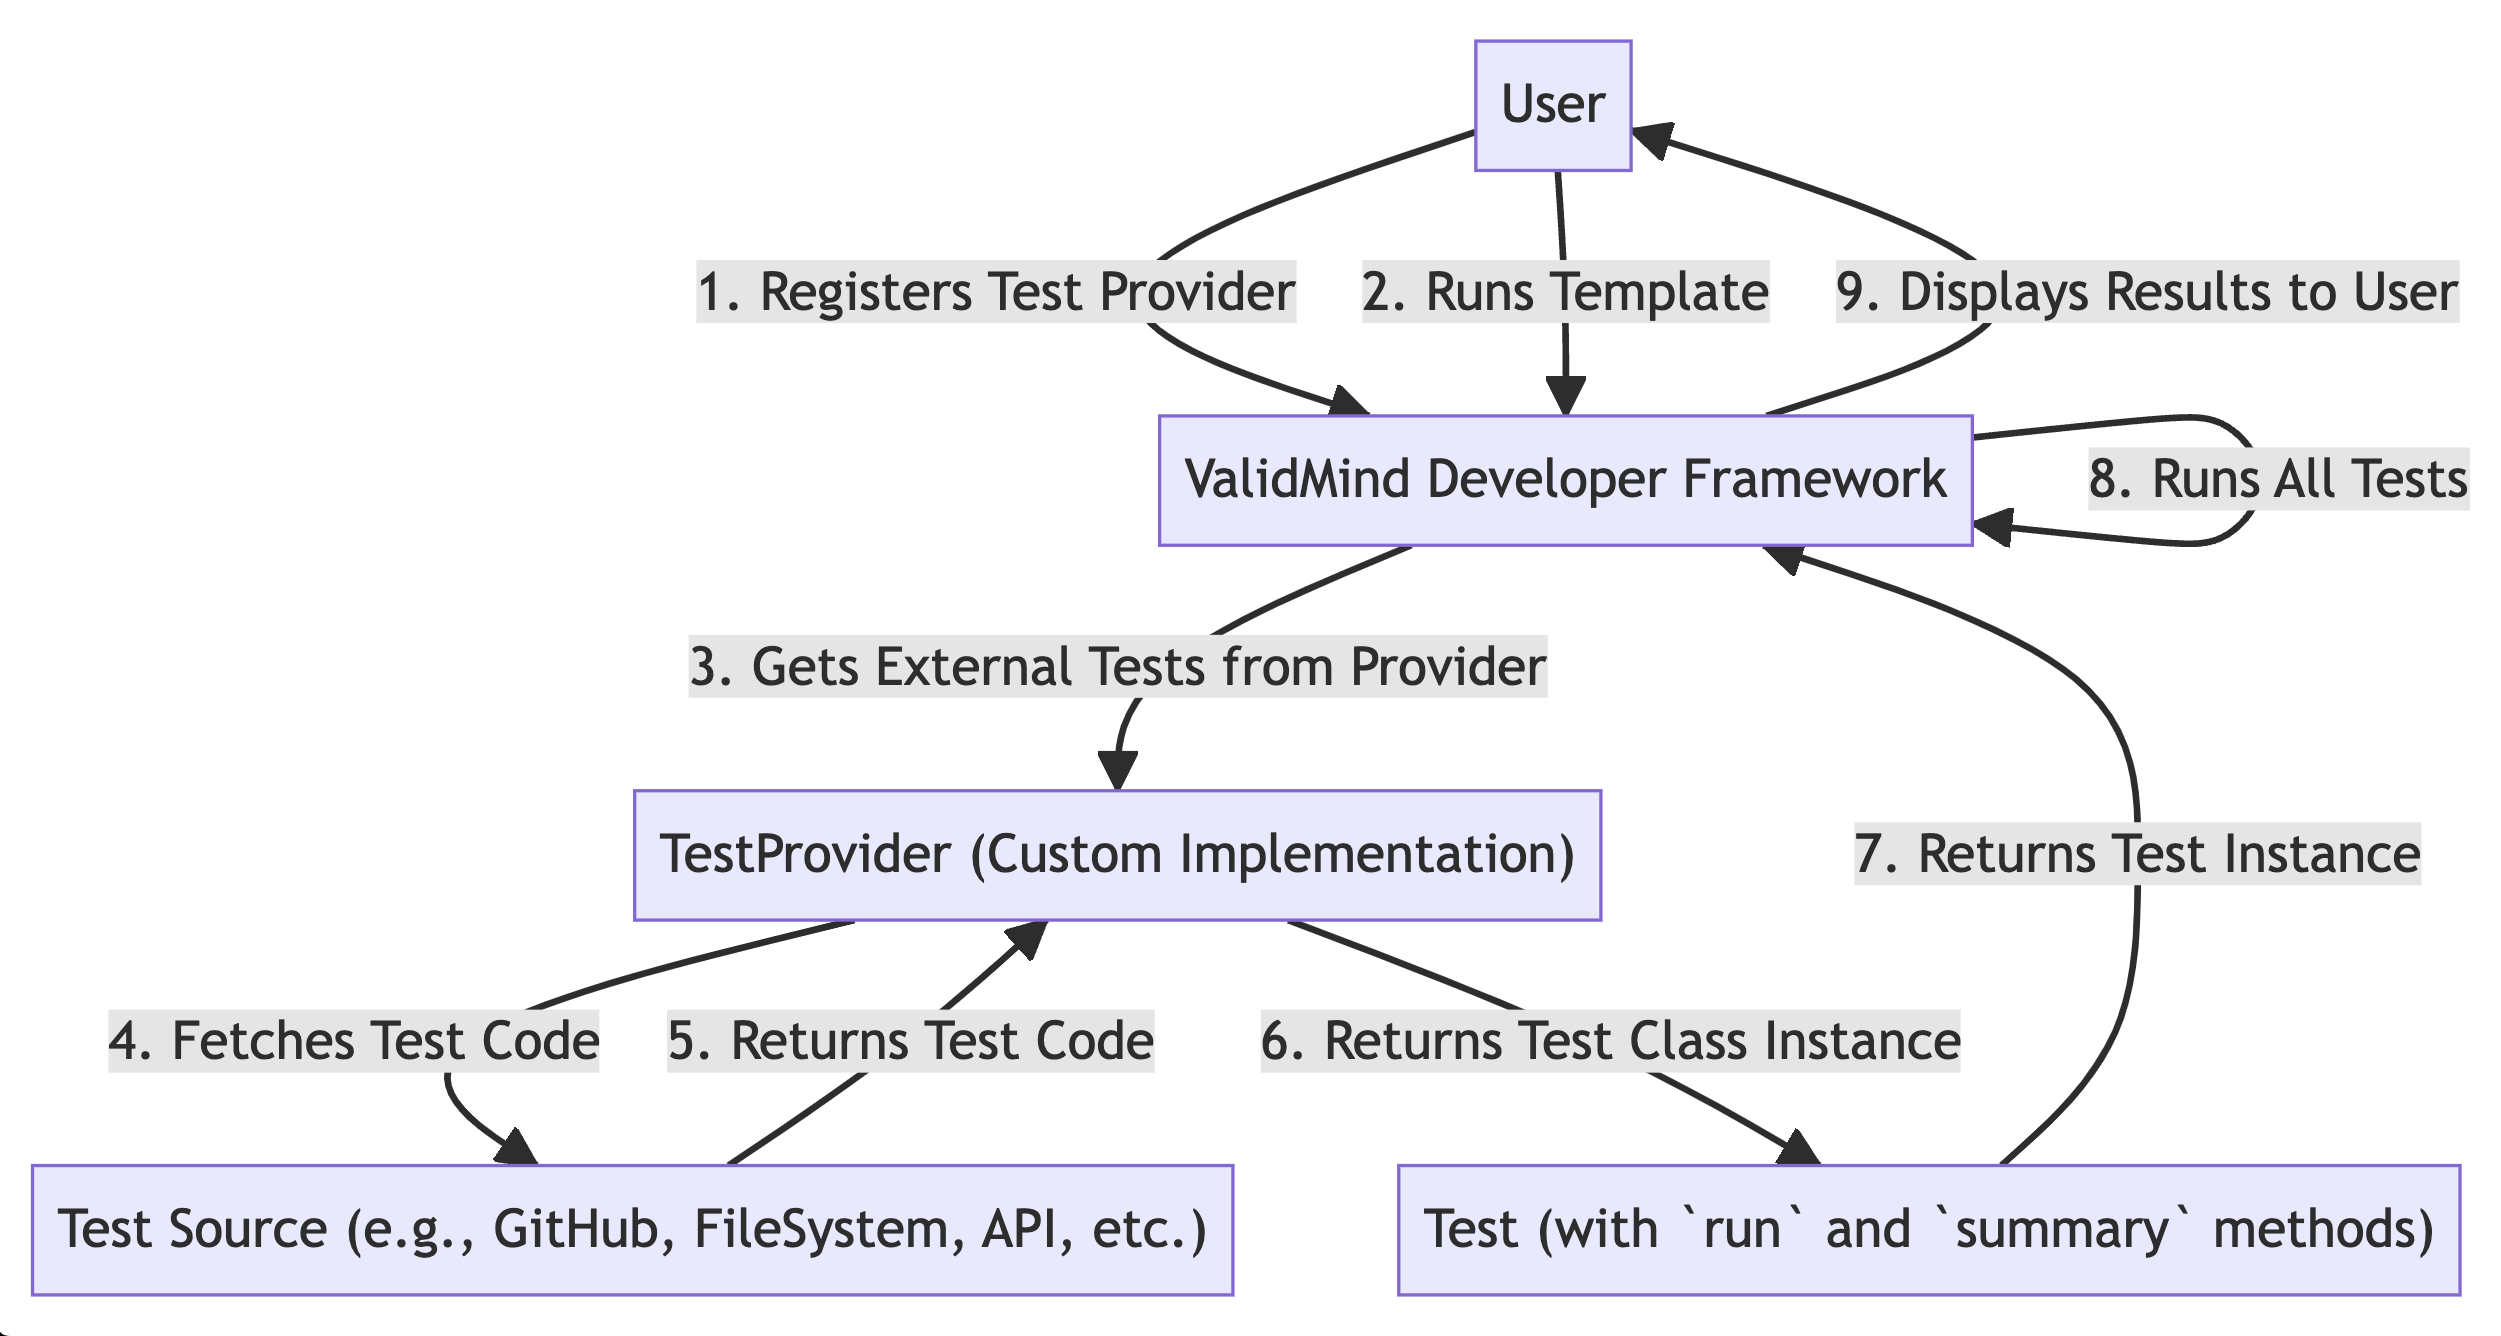

### Local Test Provider

For the Local Filesystem provider, we will just need to specify the root folder under which the provider class will look for tests.

In [9]:
from validmind.tests import LocalTestProvider, register_test_provider

local_test_provider = LocalTestProvider(root_folder="./tests")

register_test_provider(
    namespace="my_local_provider",
    test_provider=local_test_provider,
) # validmind will now call the `LocalTestProvider.load_test` method whenever it encounters a test ID that starts with `my_local_provider`

### Github Repo Test Provider

For the Github provider, we will need to specify the `org` and `repo` to pull from as well as optionally pass a `token` if the repo is private.

In [10]:
from validmind.tests import GithubTestProvider, register_test_provider

github_test_provider = GithubTestProvider(
    org="validmind",
    repo="ExternalTestProviderDemo",
    token=os.environ["GITHUB_TOKEN"],
)

register_test_provider(
    namespace="my_github_provider",
    test_provider=github_test_provider,
) # validmind will now call the `GithubTestProvider.load_test` method whenever it encounters a test ID that starts with `my_github_provider`

# New Test Registration

To "register" new tests that users have created, we mean adding it to a test provider. Now, we have defined two test providers above and we could add our new Isolation Forest Test to either. But lets go ahead and add it to our Github Test Provider. "Registering" it, in this case, is as simple as adding it to the Github repository that our Github test provider points to. If we wanted to "register" it with our local test provider, we would just need to add it to the directory that our local test provider points to. Once there, it can be immediately used by adding it to any template.

<i>Copy the above code into a new file called MyIsolationForest.py on Github</i>

# Template Updates

As explained, lets go ahead and update one of our templates with the following YAML:

```yaml
      - content_type: metric
        content_id: my_local_provider.MyCustomTest
      - content_type: metric
        content_id: my_github_provider.tests.MyIsolationForest
```

Notice how the `content_id` references the namespace and location of the test. This is how the framework will know which test provider has the test and in turn, the test provider will know where the test is located.

# Template Execution

Now that everything is setup and registered, we can go ahead and execute our template and see the results. We should see the results of our custom test in the output.

### Set up the Validmind connection

In [11]:
import validmind as vm

import xgboost as xgb

vm.init(
    api_host = "http://localhost:3000/api/v1/tracking",
    project = "cljd8ckrb00002fpowq3wcjko"
)

2023-06-26 15:47:29,625 - INFO - api_client - Connected to ValidMind. Project: Demo Project (cljd8ckrb00002fpowq3wcjko)


### Preview the template for the current project to validate that it looks correct

In [12]:
# we should see an `External Test Providers` section with two content blocks pointing to the two test providers we registered above
vm.preview_template()

Accordion(children=(Accordion(children=(HTML(value='<p>Empty Section</p>'), Accordion(children=(HTML(value='<p…

### Running the template

Now we can run the template as usual and it will use the external test providers to load the appropriate tests.

In [14]:
N = 100000

# Generate normally distributed data for 6 features, with different means and standard deviations
f1 = np.random.normal(loc=0, scale=1, size=N)
f2 = np.random.normal(loc=5, scale=5, size=N)
f3 = np.random.normal(loc=10, scale=10, size=N)
f4 = np.random.normal(loc=20, scale=20, size=N)
f5 = np.random.normal(loc=-10, scale=30, size=N)
f6 = np.random.normal(loc=-20, scale=40, size=N)

# Generate some outliers for the features
outliers_ratio = 0.01 # 1% of data are outliers
for feature in [f1, f2, f3, f4, f5, f6]:
    num_outliers = int(N * outliers_ratio)
    # Use a very different mean and standard deviation for outliers
    outliers = np.random.normal(loc=100, scale=50, size=num_outliers)
    # Replace some values with outliers
    feature[:num_outliers] = outliers

# Generate a binary target variable
y = np.random.choice([0, 1], size=N)

# Create a dataframe
df = pd.DataFrame({
    'f1': f1,
    'f2': f2,
    'f3': f3,
    'f4': f4,
    'y': y
})

train_df = df.sample(frac=0.8, random_state=0)
validation_df = df.drop(train_df.index)
test_df = df.drop(train_df.index)

X_train = train_df.drop('y', axis=1)
y_train = train_df['y']

X_val = validation_df.drop('y', axis=1)
y_val = validation_df['y']

X_test = test_df.drop('y', axis=1)
y_test = test_df['y']

model = xgb.XGBClassifier(early_stopping_rounds=10)
model.set_params(
    eval_metric=["error", "logloss", "auc"],
)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False,
)

vm_dataset = vm.init_dataset(
    dataset=df,
    target_column="y",
    class_labels={
        "0": "Negative",
        "1": "Positive",
    },
)
vm_train_ds = vm.init_dataset(
    dataset=train_df,
    type="generic",
    target_column="y",
)
vm_test_ds = vm.init_dataset(
    dataset=test_df,
    type="generic",
    target_column="y",
)
vm_model = vm.init_model(
    model,
    train_ds=vm_train_ds,
    test_ds=vm_test_ds,
)

2023-06-26 15:47:36,483 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-26 15:47:36,484 - INFO - dataset - Inferring dataset types...
2023-06-26 15:47:36,556 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-26 15:47:36,557 - INFO - dataset - Inferring dataset types...
2023-06-26 15:47:36,614 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-26 15:47:36,615 - INFO - dataset - Inferring dataset types...


In [15]:
template_config = {
    "robustness":{
        "scaling_factor_std_dev_list": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
        "accuracy_decay_threshold": 4,
    },
}
vm.run_documentation_tests(
    dataset=vm_dataset,
    model=vm_model,
    config=template_config,
)